Урок 4. Тематическое моделирование. EM-алгоритм
Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет (источник): положительные, отрицательные.

рабочие ссылки с твитами
https://disk.yandex.ru/i/v5HM-ENiGXZVpQ
https://disk.yandex.ru/i/koR5eMCToCZS2Q

как альтернатива можно скачать данные из Роспотребнадзора
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук parse_rospotrebnadzor.ipynb
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

In [1]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 38.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=e1065139a463c58cef4704e4f73e1314c7ad851257b633310efb8bad9b73bc9d
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [2]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=284f5aedcde3b84d7219ef21f89453db844d40f90ab412a1caeecc2cd752a51f
  Stored in directory: /root/.cache/pip/wheels/eb/03/0d/3bd31c983789aeb0b4d5e2ca48590288d9db1586cf5f225062
Successfully built stop_words


In [3]:
import pandas as pd
import numpy as np

import re

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words

from gensim import corpora
from gensim.models import *

In [4]:
morpher = MorphAnalyzer()

In [5]:
stopwords_list = set(get_stop_words("ru"))

In [6]:
positive = pd.read_csv('positive.csv', sep = ';', usecols = [3], names = ['text'])
positive['label'] = ['positive'] * len(positive)

negative = pd.read_csv('negative.csv', sep = ';', usecols = [3], names = ['text'])
negative['label'] = ['negative'] * len(negative)

In [7]:
df = pd.concat([positive, negative], ignore_index = True)
df.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226834 entries, 0 to 226833
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    226834 non-null  object
 1   label   226834 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [9]:
words_regex = re.compile(r'\w+')

def find_words(text, regex = words_regex):
    tokens = regex.findall(text) 
    return [w for w in tokens if w.isalpha() and len(w)>= 4] 


In [10]:
def lemmatize(words, lemmer = morpher, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words] 
    return [w for w in lemmas if not w in stopwords and w.isalpha()] 

def clear_tokens(tokens):
    string_tokens = ' '.join(tokens)
    string_tokens = re.sub(r'[A-za-z]', ' ',  string_tokens) 
    string_tokens = re.sub(r'\w+ще\b', ' ',  string_tokens) 
    string_tokens = re.sub(r'\bбл\w+', ' ',  string_tokens) 
    string_tokens = re.sub(r'значит', ' ',  string_tokens) 
    string_tokens = re.sub(r'почему', ' ',  string_tokens) 
    string_tokens = re.sub(r'свой', ' ',  string_tokens) 
    string_tokens = re.sub(r'капец', ' ',  string_tokens) 
    string_tokens = re.sub(r'который', ' ',  string_tokens)
    string_tokens = re.sub(r'это', ' ',  string_tokens)
    string_tokens = re.sub(r'весь', ' ',  string_tokens)
    string_tokens = re.sub(r'\bидио\w+', ' ',  string_tokens) 
    string_tokens = re.sub(r'\bпид\w+', ' ',  string_tokens)
    string_tokens = re.sub(r'\bхуй\w+', ' ', string_tokens)
    string_tokens = re.sub(r'\w+xу.\b', ' ',  string_tokens)
    string_tokens = re.sub(r'\w+xу\w+', ' ',  string_tokens)
    string_tokens = re.sub(r'\w+но\b', ' ',  string_tokens)
    string_tokens = re.sub(r'\bпоп\w+', ' ',  string_tokens)
    string_tokens = re.sub(r'\bпиз\w+', ' ',  string_tokens)
    string_tokens = re.sub(r'\bгов\w+', ' ',  string_tokens)
    string_tokens = re.sub(r'\bфиг\w+', ' ',  string_tokens)
    string_tokens = re.sub(r'сука', ' ',  string_tokens)
    string_tokens = re.sub(r'очень', ' ',  string_tokens)
    string_tokens = re.sub(r'лох', ' ',  string_tokens)
    string_tokens = re.sub(r'\bпи.де\w+', ' ',  string_tokens)
    string_tokens = re.sub(r'нету', ' ',  string_tokens)
    string_tokens = re.sub(r'ой', ' ',  string_tokens)
    string_tokens = re.sub(r'\bхот\w+', ' ',  string_tokens)
    string_tokens = re.sub(r'\bпрост\w+', ' ',  string_tokens)
    string_tokens = re.sub(r'\bника\w+', ' ',  string_tokens)
    string_tokens = re.sub(r'\w+ть\b', ' ',  string_tokens)
    string_tokens = re.sub(r'мочь', ' ',  string_tokens)
    clear_tokens = string_tokens.split()
    clear_tokens = [w for w in clear_tokens if len(w)>2]
    return clear_tokens

def preprocess(text):
    return (clear_tokens(lemmatize(find_words(text))))

In [11]:
df['text'] = df['text'].apply(preprocess)
df.head()

,text,label
0,"[школотый, поверь, самый, общество, предмет, тип]",positive
1,"[таки, похожий, мальчик, хороший]",positive
2,[испугаться],positive
3,"[угол, голод, порция]",positive
4,"[страшилка, создаться, ощущение, автор]",positive


In [12]:
dictionary = corpora.Dictionary(df['text'])

In [13]:
dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None)
dictionary.save('tweet.dict')
len(dictionary.keys())

8100

In [14]:
corpus = [dictionary.doc2bow(text) for text in df['text']]
corpora.MmCorpus.serialize('tweet.model', corpus)

In [15]:
mm = corpora.MmCorpus('tweet.model')
print(df['text'].values[0])
print(mm[0])

['школотый', 'поверь', 'самый', 'общество', 'предмет', 'тип']
[(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0)]


In [16]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=3)

In [17]:
lda.show_topics(num_topics=3, num_words=20, formatted=True)

[(0,
  '0.027*"дом" + 0.015*"утро" + 0.011*"час" + 0.010*"скоро" + 0.010*"найти" + 0.009*"вчера" + 0.008*"прийтись" + 0.007*"рука" + 0.007*"боль" + 0.007*"правда" + 0.007*"твиттер" + 0.007*"минута" + 0.007*"ужасный" + 0.006*"учёба" + 0.006*"чувство" + 0.006*"слово" + 0.006*"прийти" + 0.006*"твит" + 0.006*"город" + 0.006*"выходн"'),
 (1,
  '0.032*"завтра" + 0.021*"школа" + 0.016*"новый" + 0.014*"идти" + 0.014*"никто" + 0.013*"жаль" + 0.011*"настроение" + 0.011*"последний" + 0.011*"работа" + 0.011*"урок" + 0.009*"экзамен" + 0.008*"каникулы" + 0.008*"голова" + 0.008*"ночь" + 0.008*"телефон" + 0.008*"улица" + 0.007*"снег" + 0.007*"бояться" + 0.006*"маленький" + 0.006*"нужный"'),
 (2,
  '0.023*"хороший" + 0.019*"больш" + 0.014*"мама" + 0.014*"друг" + 0.014*"самый" + 0.011*"любимый" + 0.009*"неделя" + 0.009*"дело" + 0.009*"казаться" + 0.008*"жалко" + 0.008*"фильм" + 0.007*"ранний" + 0.007*"фотка" + 0.006*"глаз" + 0.006*"конец" + 0.005*"папа" + 0.005*"ребёнок" + 0.005*"слеза" + 0.005*"музыка"

In [18]:
print(lda.log_perplexity(corpus))

-8.133849956912105


In [19]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.0002934363758011013


# Визуализация

In [20]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=9f6ee1f72d2423abfe2f10e57eeda3d11cabc7322526c7f9983cb9d9443e16f2
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=ebbf9d835d571627d55393870c5b319a07d265be1894505f20e45520dee3fe45
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [21]:
import pyLDAvis.gensim_models as gensimvis

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [22]:
v_data = gensimvis.prepare(lda, corpus, dictionary)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [23]:
import pyLDAvis

In [24]:
pyLDAvis.display(v_data)

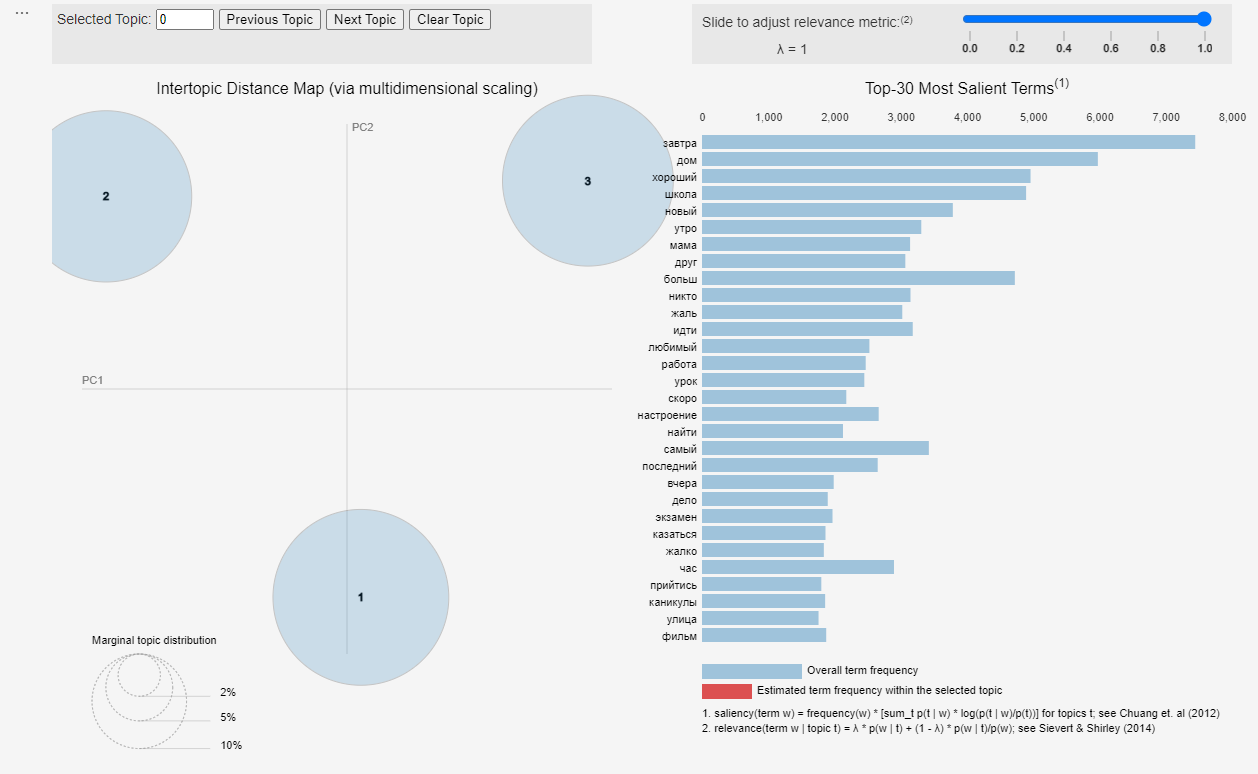

# Результаты:

У меня получились три частые темы:

1) Трудовые будни.

2) Взаимоотношений между людьми.

3) Отдых и развлечения.